# Weekly Project - Cats & Dogs Classification

![](https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg)

Welcome to the weekly project! Now it's the time to build your first ML application.

The idea is simple: "Cats vs Dogs" classification. Let's build a Flask app to help user upload their image and get the result that is a cat or dog photo.

You will see that not every time your model predicts correctly. Giving users a way to correct the answer if it's wrong or confirm if it's right will be very helpful to improve your model (make it smarter). 

Good luck, and have fun!


LINK TO DATASET: https://www.kaggle.com/c/dogs-vs-cats/data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pathlib
import IPython.display as display
import cv2
import time
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Activation
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
tf.__version__

'2.2.0-rc3'

In [ ]:
# check Pillow version number
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.0.0


In [ ]:
Learningrate = 0.001
TRAIN_DIR = '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train'
MODEL_NAME = 'Catanddog_Detect'
Img_size = 224

In [ ]:
from os import listdir
from os.path import isfile, join

In [ ]:
a = os.listdir(TRAIN_DIR)
image_paths = [os.path.join(TRAIN_DIR, f) for f in a]

In [ ]:
image_count = len(image_paths)
image_count

25179

In [ ]:
image_paths[:10]

['/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.9227.jpg',
 '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.9195.jpg',
 '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.9235.jpg',
 '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.9203.jpg',
 '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.927.jpg',
 '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.9244.jpg',
 '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.928.jpg',
 '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.9263.jpg',
 '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.9237.jpg',
 '/content/drive/My Drive/FTMLE - Tonga/Data/cat_dog/train/cat.9291.jpg']

In [ ]:
import random
all_paths = random.sample(image_paths,len(image_paths))

In [ ]:
all_paths = all_paths[:25000]

In [ ]:
# Preprocess an image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [Img_size, Img_size])
    image /= 255.0
    return image

# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [ ]:
# get labels
all_image_labels = [p.split(os.path.sep)[-1][0:3] for p in all_paths]

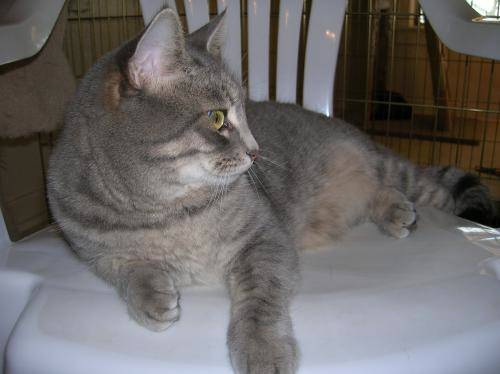

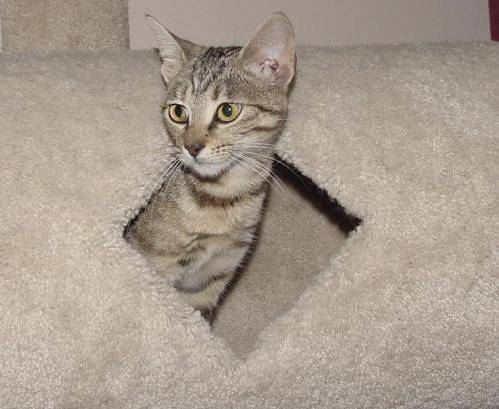

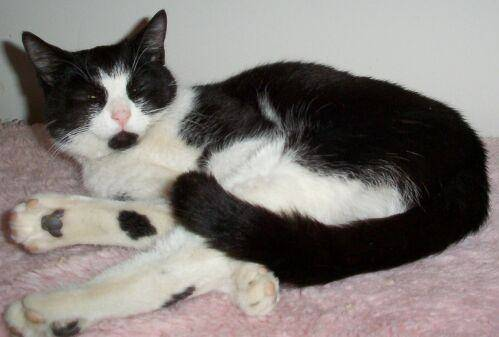

In [ ]:
import IPython.display as display

for n in range(3):
    image_path = random.choice(image_paths)
    display.display(display.Image(image_path))
    print()

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# transfer name to number
le = LabelEncoder()
labels = le.fit_transform(all_image_labels)

In [ ]:
label_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int64))

In [ ]:
label_dataset

<TensorSliceDataset shapes: (), types: tf.int64>

In [ ]:
print("First 10 labels indices: ", labels[:10])

First 10 labels indices:  [0 1 1 0 1 0 1 0 0 1]


In [ ]:
# Create dataset from image paths
path_dataset = tf.data.Dataset.from_tensor_slices(all_paths)


In [ ]:
# Create image dataset from path dataset
image_dataset = path_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [ ]:
path_dataset

<TensorSliceDataset shapes: (), types: tf.string>

In [ ]:
# Combine image dataset and image label dataset
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

In [ ]:
# Split train, test and validation set
DATASET_SIZE = 25000
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 4096

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

dataset = dataset.shuffle(buffer_size = SHUFFLE_BUFFER_SIZE)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [ ]:
# Perform mini-batch in train_dataset and test_dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Define model
def define_model():
    # load model
    model = tf.keras.applications.Xception(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = tf.keras.Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = tf.keras.optimizers.RMSprop(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = define_model()

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
# Train model
model_history = model.fit(train_dataset, epochs = 10, validation_data = val_dataset)

Epoch 1/10
136/136 [==============================] - 2305s 17s/step - loss: 1.9466 - accuracy: 0.9753 - val_loss: 1.1712 - val_accuracy: 0.9782
Epoch 2/10
136/136 [==============================] - 327s 2s/step - loss: 0.2069 - accuracy: 0.9866 - val_loss: 0.0381 - val_accuracy: 0.9890
Epoch 3/10
136/136 [==============================] - 329s 2s/step - loss: 0.0329 - accuracy: 0.9928 - val_loss: 0.0512 - val_accuracy: 0.9871
Epoch 4/10
136/136 [==============================] - 325s 2s/step - loss: 0.0320 - accuracy: 0.9936 - val_loss: 0.0841 - val_accuracy: 0.9841
Epoch 5/10
136/136 [==============================] - 327s 2s/step - loss: 0.0264 - accuracy: 0.9937 - val_loss: 0.0418 - val_accuracy: 0.9884
Epoch 6/10
136/136 [==============================] - 328s 2s/step - loss: 0.0162 - accuracy: 0.9952 - val_loss: 0.0548 - val_accuracy: 0.9895
Epoch 7/10
136/136 [==============================] - 326s 2s/step - loss: 0.0136 - accuracy: 0.9965 - val_loss: 0.0345 - val_accuracy: 0.99

In [ ]:
# Evaluate model
model.evaluate(test_dataset)

29/29 [==============================] - 46s 2s/step - loss: 0.0347 - accuracy: 0.9925


[0.034704163670539856, 0.9924569129943848]

In [ ]:
# Save model
model.save('Catanddog_Detect.h5')